# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## This notebook was last tested with IPython notebook 4.1.0 using Python 2.7
### (If you have trouble running this notebook, please check version compatibility)

## First, do the necessary set-up (run the code block below, first)

In [1]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from ipywidgets import interact, interact_manual, fixed
from api_ipython import SkaIPythonAPI as iapi
from parameter_definitions import *
from parameter_definitions import Constants as c
from implementation import Implementation as imp
%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Mid)

available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)

# The High Priority Science Objective list below includes the HPSOs that were originally intended for 
# The Survey telescope. These have since been reassigned to Mid.
available_hpsos = [HPSOs.hpso_max_Low_c, HPSOs.hpso_max_Low_s, HPSOs.hpso_max_Mid_c, HPSOs.hpso_max_Mid_s, 
                   HPSOs.hpso01c, HPSOs.hpso01s, HPSOs.hpso02A, HPSOs.hpso02B, HPSOs.hpso14, HPSOs.hpso14c, HPSOs.hpso14s, 
                   HPSOs.hpso22, HPSOs.hpso37a, HPSOs.hpso37b, HPSOs.hpso38a, HPSOs.hpso38b, 
                   HPSOs.hpso13c, HPSOs.hpso13s, HPSOs.hpso15c, HPSOs.hpso15s, 
                   HPSOs.hpso27, HPSOs.hpso33, HPSOs.hpso37c]

available_hpsos.sort()

available_modes     = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg)
available_modes_all = available_modes + (ImagingModes.All,)
verbose_display = False

## Using default values, we can compare telescopes side-by-side

In [2]:
interact_manual(iapi.compare_telescopes_default, 
                telescope_1=available_teles, telescope_2=available_teles, band_1=available_bands,
                band_2=available_bands, mode_1=available_modes_all, mode_2=available_modes_all,
                verbose=verbose_display);

## Using default values, can compute results for the High Priority Science Objectives

In [2]:
interact_manual(iapi.evaluate_hpso_optimized, hpso_key=available_hpsos, verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [ ]:
interact(iapi.evaluate_telescope_manual, max_baseline=(10000,200000), Nf_max = (1,256000,1), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         telescope=available_teles, band=available_bands, mode=available_modes_all, verbose=verbose_display);

### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

In [ ]:
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10000,200000), Nf_max = (1,256000,1), telescope=available_teles, 
         band=available_bands, mode=available_modes_all, verbose=verbose_display);

## illustrating 1D "parameter sweep" + visualization functionality.

Starting sweep of parameter Bmax, evaluating expression Rflop over range (15000, 150000) in 9 steps (i.e. 10 data points)
> 0.0% done: Evaluating Rflop for Bmax = 15000
> 10.0% done: Evaluating Rflop for Bmax = 30000
> 20.0% done: Evaluating Rflop for Bmax = 45000
> 30.0% done: Evaluating Rflop for Bmax = 60000
> 40.0% done: Evaluating Rflop for Bmax = 75000
> 50.0% done: Evaluating Rflop for Bmax = 90000
> 60.0% done: Evaluating Rflop for Bmax = 105000
> 70.0% done: Evaluating Rflop for Bmax = 120000
> 80.0% done: Evaluating Rflop for Bmax = 135000
> 90.0% done: Evaluating Rflop for Bmax = 150000
done with parameter sweep!


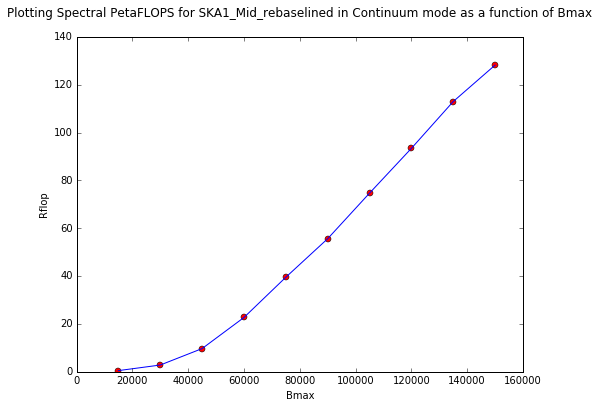

15000.0 , 0.497840716698
30000.0 , 2.83372895362
45000.0 , 9.71227205071
60000.0 , 22.7142243327
75000.0 , 39.5347011643
90000.0 , 55.6501296082
105000.0 , 74.6983102951
120000.0 , 93.4196420399
135000.0 , 113.004505614
150000.0 , 128.248334657


In [3]:
from IPython.display import display, HTML

expression = 'Rflop'
parameter = 'Bmax'
param_val_min =15000
param_val_max = 150000
number_steps = 9
telescope = Telescopes.SKA1_Mid
immode = ImagingModes.Continuum
band=Bands.Mid1

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(param_values, results) = iapi.eval_param_sweep_1d(telescope, immode, band=band, 
                                                   expression=expression, parameter=parameter, param_val_min=param_val_min,
                                                   param_val_max=param_val_max, number_steps=number_steps, verbose=False)
header = 'Plotting Spectral PetaFLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
iapi.plot_line_datapoints(header, param_values, np.array(results)/c.peta, xlabel=parameter, ylabel=expression)

for i in range(len(param_values)):
               print param_values[i], ",", (results[i])/c.peta

## illustrating 2D "parameter sweep" + visualization functionality.

In [ ]:
from IPython.display import display, HTML

telescope = Telescopes.SKA1_Mid
band = Bands.Mid1
immode = ImagingModes.Continuum
expression = 'Rflop'
parameters = ('Nf_out', 'minimum_channels')
parameter_ranges = ((100,500),(100,500))
number_steps = 4
verbose = False

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(p1_values, p2_values, results) = iapi.eval_param_sweep_2d(telescope, immode, band=band, 
                                                           expression=expression, parameters=parameters, 
                                                           params_ranges=parameter_ranges, number_steps=number_steps, 
                                                           verbose=verbose)


iapi.plot_2D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], contours=np.array((0.5, 1.0)))
iapi.plot_3D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], zlabel=expression, contours=np.array((0.5, 1.0)))